In [60]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the environment variable to point to the license file on your Desktop
os.environ['GRB_LICENSE_FILE'] = os.path.expanduser('~/Desktop/gurobi.lic')

Loading data:

In [2]:
data = pd.read_csv('data_observed.csv')
data_observed = data[['X', 'Y', 'T', 'ips NN']]

In [61]:
def solve_extended_dual_lp(df_observed, Gamma = 2, epsilon_0 = 1000, epsilon_1 = 1000):
                          
    m = gp.Model("ExtendedDualLP")
    m.setParam("OutputFlag", 0)  # Suppress solver output

    #data
    X_vals = df_observed["X"].values
    T_vals = df_observed["T"].values
    Y_vals = df_observed["Y"].values
    w_hat = df_observed["ips NN"].values
    n = len(df_observed)
    I = range(n)


    I0 = [i for i in I if T_vals[i] == 0]
    I1 = [i for i in I if T_vals[i] == 1]
    Tset = [0, 1]


    #d(x_i, x_j).
    def d(i, j):
        return (X_vals[i] - X_vals[j])**2


    eps = {0: epsilon_0, 1: epsilon_1}

    #Decision Variables

    beta, gamma, theta, mu, nu = {}, {}, {}, {}, {}

    for t in Tset:
        beta[t] = m.addVar(lb=0.0, name=f"beta_{t}")

    for t in Tset:
        for i_ in I:
            gamma[(t, i_)] = m.addVar(lb = -GRB.INFINITY, name=f"gamma_{t}_{i_}")
    for t in Tset:
        for i_ in (I0 if t==0 else I1):
            theta[(t, i_)] = m.addVar(lb = -GRB.INFINITY, name=f"theta_{t}_{i_}")

    for i_ in I:
        mu[i_] = m.addVar(lb=0.0, name=f"mu_{i_}")
        nu[i_] = m.addVar(lb=0.0, name=f"nu_{i_}")

    policy = {}
    for i_ in I:
        for t in Tset:
            policy[(t,i_)] = m.addVar(lb=0.0, name=f"pi_{t}_{i_}")



    #obejctinve function:

    
    obj_expr = gp.LinExpr()
    for t in Tset:
       obj_expr.addTerms(-eps[t], beta[t])
    for t in Tset:
        for i_ in I:
            obj_expr.addTerms(1.0 / n, gamma[(t, i_)])
    for i_ in I:
        obj_expr.addTerms((1.0 + (1.0 / Gamma)*(w_hat[i_] - 1.0)), mu[i_])
        obj_expr.addTerms(-(1.0 + Gamma*(w_hat[i_] - 1.0)), nu[i_])


    m.setObjective(obj_expr, GRB.MAXIMIZE)



    #Constraints


    for t in Tset:
        for i_ in (I0 if t == 0 else I1):
            lhs = gp.LinExpr()
            lhs += (1.0 / n) * policy[t,i_] * Y_vals[i_]
            lhs.addTerms(1/ (sum(w_hat)), theta[(t, i_)])
            lhs.addTerms(-1.0, mu[i_])
            lhs.addTerms(1.0, nu[i_])
            m.addConstr(lhs >= 0, name=f"cA_t{t}_i{i_}")


    for t in Tset:
        for j_ in (I0 if t == 0 else I1):
            for i_ in I:
                lhs = gp.LinExpr()
                lhs.addTerms(d(i_, j_), beta[t])
                lhs.addTerms(-1.0, gamma[(t, i_)])
                lhs.addTerms(-1.0, theta[(t, j_)])
                m.addConstr(lhs >= 0, name=f"cB_t{t}_i{i_}_j{j_}")
                
    #policy constraint
    for i_ in I:
        lhs = gp.LinExpr()
        for t in Tset:
            lhs.addTerms(1.0, policy[(t,i_)])
        m.addConstr(lhs == 1.0, name=f"C3_piSum_i{i_}")


    #Solve
    m.optimize()

    #Sol
    if m.status == GRB.OPTIMAL:

        # Extract variable solutions
        beta_sol  = {t: beta[t].X  for t in Tset}
        gamma_sol = {(t,i_): gamma[(t,i_)].X for t in Tset for i_ in I}
        theta_sol = {(t,i_): theta[(t,i_)].X for t in Tset for i_ in (I0 if t==0 else I1)}
        mu_sol    = {i_: mu[i_].X for i_ in I}
        nu_sol    = {i_: nu[i_].X for i_ in I}
        pi_sol    = {(t,i_): policy[(t,i_)].X for t in Tset for i_ in I}
        

        return {
            "objective_value": m.objVal,
            "beta":  beta_sol,
            "gamma": gamma_sol,
            "theta": theta_sol,
            "mu": mu_sol,
            "nu": nu_sol,
            "pi": pi_sol
        }
    else:
        print(f"Model ended with status {m.status}, not OPTIMAL.")
        return None

Solving dual LP for Gamma = 1
Model ended with status 4, not OPTIMAL.
Solving dual LP for Gamma = 2
Model ended with status 4, not OPTIMAL.
Solving dual LP for Gamma = 3
Model ended with status 4, not OPTIMAL.


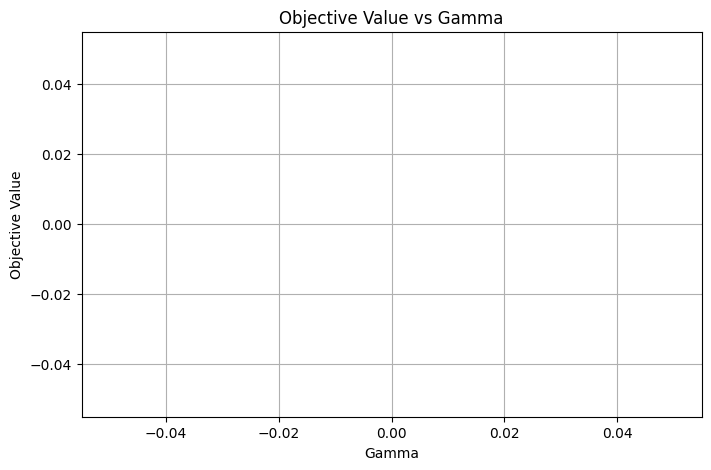

In [63]:
Gamma_values = np.arange(1, 4)

objective_values = []
pi_values = []
Tset = [0, 1]
I = range(1000)
master_df = pd.DataFrame()
master_df["X"] = data_observed["X"].values


for Gamma in Gamma_values:
    print(f"Solving dual LP for Gamma = {Gamma}")
    sol = solve_extended_dual_lp(data_observed, Gamma=Gamma)
    if sol is not None:
        obj_val = sol["objective_value"]
        pi_sol = sol["pi"]  
        pi_treatment_1 = [pi_sol[(1, i_)] for i_ in I]  
    else:
        obj_val = np.nan 
    objective_values.append(obj_val)
    
    master_df[f"pi_1_Gamma{Gamma}"] = pi_treatment_1







# Plot the objective values versus Gamma
plt.figure(figsize=(8, 5))
plt.plot(Gamma_values, objective_values, marker='o', linestyle='-')
plt.xlabel('Gamma')
plt.ylabel('Objective Value')
plt.title('Objective Value vs Gamma')
plt.grid(True)
plt.show()

In [56]:
objective_values_df = pd.DataFrame({
    'Gamma': Gamma_values,
    'Objective_Value': objective_values
})

objective_values_df.to_csv('objective_values_final.csv', index=False)

In [59]:
print(master_df.head())
master_df.to_csv('optimal_policy.csv', index = False)

          X  pi_1_Gamma4  pi_1_Gamma5  pi_1_Gamma6  pi_1_Gamma7  pi_1_Gamma8  \
0  0.496714          1.0          1.0          1.0          1.0          1.0   
1 -0.138264          1.0          1.0          1.0          1.0          1.0   
2  0.647689          1.0          1.0          1.0          1.0          1.0   
3  1.523030          0.0          0.0          0.0          0.0          0.0   
4 -0.234153          0.0          0.0          0.0          0.0          0.0   

   pi_1_Gamma9  pi_1_Gamma10  pi_1_Gamma11  pi_1_Gamma12  pi_1_Gamma13  \
0          1.0           1.0           1.0           1.0           1.0   
1          1.0           1.0           1.0           1.0           1.0   
2          1.0           1.0           1.0           1.0           1.0   
3          0.0           0.0           0.0           0.0           0.0   
4          0.0           0.0           0.0           0.0           0.0   

   pi_1_Gamma14  
0           1.0  
1           1.0  
2           1.0  
3 